<a href="https://colab.research.google.com/github/busyML/Petfinder.com-Adoption-Time-Predictor/blob/master/petfinder_com_adoption_speed_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import pandas as pd #Pandas is the most popular library for manipulating data. Think of it as an Excel but a million times faster and more practical.
import numpy as np # This library allows to easily carry out simple and complex mathematical operations.
import matplotlib.pyplot as plt #Allows us to plot data, create graphs and visualize data. Perfect for your Powerpoint slides ;)
import sklearn #The one and only. This amazing library holds all the secrets. Containing powerful algorithms packed in a single line of code, this is where the magic will happen.
import sklearn.model_selection # more of sklearn. It is a big library, but trust me it is worth it.
import sklearn.preprocessing 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score,mean_absolute_error,mean_squared_error,precision_score,recall_score, accuracy_score,f1_score
from sklearn.utils import shuffle
import os


import random # Allows us to call random numbers, occasionally very useful.
import pprint#Allows us to neatly display text
from collections import OrderedDict

import seaborn as sns


#Introduction
Hi everyone, I hope the title of this Kernel made caused you to clickbait here. The main discussion point of this kernel are Feature creating and Model speration. These allowed me to get slightly better results and perhaps someone with more experience ( i am but a beginner) would be able to make better use of these

I'm importing the Quadratic Weighted Kappa function that [Aman Arora was so kind to share for all of us](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps):

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix

def quadratic_kappa(y_true, y_pred):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((5,5))
    O = confusion_matrix(y_true, y_pred)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(5-1)**2)
    
    act_hist=np.zeros([5])
    for item in y_true: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([5])
    for item in y_pred: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

I always found this awesome correlation matrix function provided by [Enrique Herroreos in his kernel](https://www.kaggle.com/kikexclusive/curiosity-didn-t-kill-the-cat-all-in-one). Big up!

In [0]:
def plot_correlation_matrix(df):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Part I - Data Cleaning

In [0]:
#Let's load our data
print(os.listdir("../input"))

data = pd.read_csv("../input/train/train.csv")
data.columns

['train', 'test', 'breed_labels.csv', 'train_sentiment', 'test_sentiment', 'test_metadata', 'train_images', 'train_metadata', 'state_labels.csv', 'color_labels.csv', 'test_images']


Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

### Step 1 - Data Dropping

In [0]:
data.set_index('PetID', inplace=True)
#I'm not going to use NLP in this Kernel, soz!
data.drop(columns=['RescuerID','Name','Description'], inplace=True)

#Shuffling data... Just in case
data= data.sample(frac=1, random_state=85)

data.head() 

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,
a22a8a017,2,1,254,266,2,1,2,3,1,1,2,2,2,1,1,0,41401,0,2.0,4
29ffe21fe,2,2,266,266,2,1,7,0,2,1,2,1,2,1,1,0,41326,0,11.0,2
7bb118200,2,3,266,266,2,5,7,0,2,1,1,1,2,1,1,50,41326,0,3.0,2
f120723d0,2,1,265,266,3,2,3,0,2,1,2,2,2,1,3,0,41326,0,0.0,4
b94b99757,1,3,307,307,2,1,2,0,2,2,1,1,2,1,1,0,41326,2,2.0,4


### Step 2 - Feature Creation

So here is where the fun begins. There were some features I weren't too happy with, namely the "States", "Breeds" and "Colours".

For the Breeds an States, I though One-Hot-Encoding would be the best idea because I dataset is relatively small. So what I wanted to find was data that would be numerical and hierchacical to substitute with. The question became, what information does the State and Breed provide us with?

* **For the States** the following two properties would have a direct impact on the Adoption Speed : Population Size and Internet Penetration . So I added them to the state_labels.csv. ( I couldn't find a dataset on the internet penetration rate per state so I used urbanization rate as the closest proxy). You can find t[he complete database here](https://raw.githubusercontent.com/busyML/Petfinder.com-Adoption-Time-Predictor/master/state_labels.csv)





In [0]:
states = pd.read_csv('../input/state_labels.csv')


states.at[0, "State Urbanisation"] = 71.9
states.at[1, "State Urbanisation"] = 64.6
states.at[2, "State Urbanisation"] = 42.4
states.at[3, "State Urbanisation"] = 100
states.at[4, "State Urbanisation"] = 82.3
states.at[5, "State Urbanisation"] = 86.5
states.at[6, "State Urbanisation"] = 66.5
states.at[7, "State Urbanisation"] = 50.5
states.at[8, "State Urbanisation"] = 69.7
states.at[9, "State Urbanisation"] = 51.4
states.at[10, "State Urbanisation"] = 90.8
states.at[11, "State Urbanisation"] = 54
states.at[12, "State Urbanisation"] = 53.8
states.at[13, "State Urbanisation"] = 91.4
states.at[14, "State Urbanisation"] = 59.1

states.at[0, "State Population"] = 3348283
states.at[1, "State Population"] = 1890098
states.at[2, "State Population"] = 1459994
states.at[3, "State Population"] = 1627172
states.at[4, "State Population"] = 86908
states.at[5, "State Population"] = 788706
states.at[6, "State Population"] = 997071
states.at[7, "State Population"] = 1443365
states.at[8, "State Population"] = 2258428
states.at[9, "State Population"] = 227025
states.at[10, "State Population"] = 1520143
states.at[11, "State Population"] = 3117405
states.at[12, "State Population"] = 72420009
states.at[13, "State Population"] = 5411324
states.at[14, "State Population"] = 1015776.9




states

,StateID,StateName,State Urbanisation,State Population
0,41336,Johor,71.9,3348283.0
1,41325,Kedah,64.6,1890098.0
2,41367,Kelantan,42.4,1459994.0
3,41401,Kuala Lumpur,100.0,1627172.0
4,41415,Labuan,82.3,86908.0
5,41324,Melaka,86.5,788706.0
6,41332,Negeri Sembilan,66.5,997071.0
7,41335,Pahang,50.5,1443365.0
8,41330,Perak,69.7,2258428.0
9,41380,Perlis,51.4,227025.0


In [0]:
#We convert the label dataframe into a dictionary that we then map onto our train dataframe:
states_ubran_dict=states.set_index('StateID')['State Urbanisation'].to_dict()
states_pop_dict=states.set_index('StateID')['State Population'].to_dict()

data["State Urbanisation"]=data["State"].map(states_ubran_dict)
data["State Population"]=data["State"].map(states_pop_dict)
data.drop(columns="State", inplace= True)


data.head()


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,State Urbanisation,State Population
PetID,,,,,,,,,,,,,,,,,,,,,
a22a8a017,2,1,254,266,2,1,2,3,1,1,2,2,2,1,1,0,0,2.0,4,100.0,1627172.0
29ffe21fe,2,2,266,266,2,1,7,0,2,1,2,1,2,1,1,0,0,11.0,2,91.4,5411324.0
7bb118200,2,3,266,266,2,5,7,0,2,1,1,1,2,1,1,50,0,3.0,2,91.4,5411324.0
f120723d0,2,1,265,266,3,2,3,0,2,1,2,2,2,1,3,0,0,0.0,4,91.4,5411324.0
b94b99757,1,3,307,307,2,1,2,0,2,2,1,1,2,1,1,0,2,2.0,4,91.4,5411324.0


I had a similar feeling about the breed feature, I wanted a way to be able to rank each breed. So I took the breed_labels file and added to it a ranked popularity based on [this dataset of breed popularity ](https://www.akc.org/expert-advice/news/most-popular-dog-breeds-full-ranking-list/). Here, the smaller the number, the greater the popularity.

In [0]:
breeds=states = pd.read_csv('../input/breed_labels.csv')

breeds.at[0,"Ranked Popularity"]= 147
#Let's speed this up. Here is a list of the ranked popularity with the same index as the breed labels.
breeds_popularity_list=[147,93,55,190,47,59,5,118,126,190,148,86,190,56,190,17,137,84,39,6,125,141,151,120,190,44,190,25,46,130,1,190,116,50,190,132,124,190,38,92,102,21,85,11,98,127,26,94,60,51,69,175,37,190,190,190,24,19,43,32,79,190,179,1,76,184,140,190,29,40,130,15,81,171,13,63,182,16,190,67,190,5,52,178,113,95,70,27,134,152,118,190,145,190,173,177,96,99,187,4,156,136,2,10,190,62,80,158,3,104,14,66,75,156,183,23,160,190,12,165,189,72,114,164,73,74,111,78,119,190,190,190,190,87,129,190,190,163,157,190,1,138,190,100,77,169,33,70,190,28,190,71,190,152,190,107,190,36,128,170,91,190,105,89,70,190,53,190,88,190,160,174,190,166,159,113,176,22,7,54,190,31,142,162,97,139,96,41,8,48,123,57,190,110,90,168,58,150,104,64,140,70,24,45,20,12,106,172,188,122,190,90,177,60,7,161,149,107,190,153,121,101,190,112,131,30,34,15,133,109,42,49,61,2,99,65,70,143,1,9,200,10,22,6,42,12,28,18,16,34,31,3,20,39,5,50,36,41,50,13,50,9,5,5,50,50,7,25,1,50,38,42,24,28,37,42,6,29,50,50,14,21,11,11,11,4,6,26,2,17,7,23,12,15,50,30,50,27,8,50,50,19,50,10,33,41,45]
i=0
#With a simple "for loop", we can add the whole list the breed_label dataframe
for i in range (len(breeds_popularity_list)):
        breeds.at[i,"Ranked Popularity"]= breeds_popularity_list[i]
breeds

,BreedID,Type,BreedName,Ranked Popularity
0,1,1,Affenpinscher,147.0
1,2,1,Afghan Hound,93.0
2,3,1,Airedale Terrier,55.0
3,4,1,Akbash,190.0
4,5,1,Akita,47.0
5,6,1,Alaskan Malamute,59.0
6,7,1,American Bulldog,5.0
7,8,1,American Eskimo Dog,118.0
8,9,1,American Hairless Terrier,126.0
9,10,1,American Staffordshire Terrier,190.0


In [0]:
breeds_dictionary=breeds.set_index('BreedID')['Ranked Popularity'].to_dict()

#We map the dictionary onto the train dataframe
data["Breed1"]=data["Breed1"].map(breeds_dictionary)
data["Breed2"]=data["Breed2"].map(breeds_dictionary)

#if we  only have one breed for both columns, then we'll repeat the bread, indicating that this is a pure breed
data["Breed2"].fillna(data["Breed1"],inplace=True)
data["Breed1"].fillna(data["Breed2"],inplace=True)


data.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,State Urbanisation,State Population
PetID,,,,,,,,,,,,,,,,,,,,,
a22a8a017,2,1,5.0,7.0,2,1,2,3,1,1,2,2,2,1,1,0,0,2.0,4,100.0,1627172.0
29ffe21fe,2,2,7.0,7.0,2,1,7,0,2,1,2,1,2,1,1,0,0,11.0,2,91.4,5411324.0
7bb118200,2,3,7.0,7.0,2,5,7,0,2,1,1,1,2,1,1,50,0,3.0,2,91.4,5411324.0
f120723d0,2,1,50.0,7.0,3,2,3,0,2,1,2,2,2,1,3,0,0,0.0,4,91.4,5411324.0
b94b99757,1,3,200.0,200.0,2,1,2,0,2,2,1,1,2,1,1,0,2,2.0,4,91.4,5411324.0


And now we need to do the same with colors. At first I tried to use one hot encoding and create 7 new columns but that matrix was too sparse for my liking. So what I decided to do was assign a intensity value between 0 and 1 ( 0 being "white" and 1 being "Black") and mapped the colour value that way. The model seemed to perform better this way:

In [0]:
colors = pd.read_csv('../input/color_labels.csv')


colors.at[0, "Color Intensity"] = 1
colors.at[1, "Color Intensity"] = 0.883
colors.at[2, "Color Intensity"] = 0.667
colors.at[3, "Color Intensity"] = 0.333
colors.at[4, "Color Intensity"] = 0.167
colors.at[5, "Color Intensity"] = 0.5
colors.at[6, "Color Intensity"] = 0

colors

,ColorID,ColorName,Color Intensity
0,1,Black,1.000
1,2,Brown,0.883
2,3,Golden,0.667
3,4,Yellow,0.333
4,5,Cream,0.167
5,6,Gray,0.500
6,7,White,0.000


In [0]:
color_dictionary=colors.set_index('ColorID')['Color Intensity'].to_dict()


data["Color2"]= data["Color2"].apply(lambda x: None if x==0 else x)
data["Color3"]= data["Color3"].apply(lambda x: None if x==0 else x)


data["Color1"]=data["Color1"].map(color_dictionary)
data["Color2"]=data["Color2"].map(color_dictionary)
data["Color3"]=data["Color3"].map(color_dictionary)

#This always to standerize the colors, if color1=color2=color3, then the pet only has one solid color
data["Color2"].fillna(data["Color1"],inplace=True)
data["Color3"].fillna(data["Color2"],inplace=True)

#for the second row (id=29ffe21fe), we can see that that the pet is black and white
data.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,State Urbanisation,State Population
PetID,,,,,,,,,,,,,,,,,,,,,
a22a8a017,2,1,5.0,7.0,2,1.000,0.883,0.667,1,1,2,2,2,1,1,0,0,2.0,4,100.0,1627172.0
29ffe21fe,2,2,7.0,7.0,2,1.000,0.000,0.000,2,1,2,1,2,1,1,0,0,11.0,2,91.4,5411324.0
7bb118200,2,3,7.0,7.0,2,0.167,0.000,0.000,2,1,1,1,2,1,1,50,0,3.0,2,91.4,5411324.0
f120723d0,2,1,50.0,7.0,3,0.883,0.667,0.667,2,1,2,2,2,1,3,0,0,0.0,4,91.4,5411324.0
b94b99757,1,3,200.0,200.0,2,1.000,0.883,0.883,2,2,1,1,2,1,1,0,2,2.0,4,91.4,5411324.0


### Step 2- Feature Standarization

I'm only going to to use some pretty basic Label Encoding here...

In [0]:
data["Vaccinated"]=data["Vaccinated"].apply(lambda x:1 if x==1 else 0)
data["Dewormed"]=data["Dewormed"].apply(lambda x:1 if x==1 else 0)
data["Sterilized"]=data["Sterilized"].apply(lambda x:1 if x==1 else 0)
#data["Gender"]=data["Gender"].apply(lambda x:1 if x==2 else 0)


data.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,State Urbanisation,State Population
PetID,,,,,,,,,,,,,,,,,,,,,
a22a8a017,2,1,5.0,7.0,2,1.000,0.883,0.667,1,1,0,0,0,1,1,0,0,2.0,4,100.0,1627172.0
29ffe21fe,2,2,7.0,7.0,2,1.000,0.000,0.000,2,1,0,1,0,1,1,0,0,11.0,2,91.4,5411324.0
7bb118200,2,3,7.0,7.0,2,0.167,0.000,0.000,2,1,1,1,0,1,1,50,0,3.0,2,91.4,5411324.0
f120723d0,2,1,50.0,7.0,3,0.883,0.667,0.667,2,1,0,0,0,1,3,0,0,0.0,4,91.4,5411324.0
b94b99757,1,3,200.0,200.0,2,1.000,0.883,0.883,2,2,1,1,0,1,1,0,2,2.0,4,91.4,5411324.0


In [0]:
#Let's just save our formatted data just in case.

data.to_csv("formated_data_petfinder.csv")


### Step 3- Feature Selection

So let's start doing so analysis on our data. First, let's check what the most important features seem to be:

In [0]:
#creating our x datasheet, which contains all our data except for the ['AdoptionSpeed'] column.
x=data.drop(columns='AdoptionSpeed')


#The ['AdoptionSpeed'] column extracted.
y=data['AdoptionSpeed']

In [0]:
#Checking the features that are correlated to the target feature (Adoption speed)
for columnname in x.columns: 
    if abs(x[columnname].corr(y)) >0.095 :    
      print('The Correlation Between',columnname,'and Adoption Speed is significant:', abs(x[columnname].corr(y)))

The Correlation Between Age and Adoption Speed is significant: 0.10050993288307603
The Correlation Between Breed1 and Adoption Speed is significant: 0.15518576710453003
The Correlation Between Breed2 and Adoption Speed is significant: 0.15506990004738466
The Correlation Between Vaccinated and Adoption Speed is significant: 0.10508231556721716
The Correlation Between Sterilized and Adoption Speed is significant: 0.1673711787663975


From this we can learn that the Breed, Age, Vaccination and Sterilization seem to be key predictors ( there might be others of course.)

Let's now use a Decision Tree to keeping viewing the Feature Importance.

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
feature_importance_indicator=ExtraTreesClassifier(n_estimators = 100)

#Then we ask this algorithm, now dubbed as "feature_importance_indicator", to learn from our data x ( the indicators) and y( the Adoption Speed outcome):

feature_importance_indicator.fit(x,y)

#We then ask the model politely to create a list of which columns it learnt the most from and which columns didn't help it at all, for this we use the "feature_importances_" command:

importance_dict= dict(zip(x.columns, (feature_importance_indicator.feature_importances_)))

#We sort the list in descending order so that it is quicker to analyse.

importance_dict_sorted= OrderedDict(sorted(importance_dict.items(), key=lambda x:x[1],reverse=1))

#The "pprint" commnad allows us to print things out nicely.

pprint.pprint(importance_dict_sorted)

OrderedDict([('Age', 0.15919036042939863),
             ('PhotoAmt', 0.1470675845948257),
             ('Color1', 0.07757744100100422),
             ('Color2', 0.07312848099439986),
             ('Color3', 0.06302178456204628),
             ('Breed1', 0.051173761947483666),
             ('Quantity', 0.048184939590089175),
             ('Breed2', 0.04809002723376961),
             ('Fee', 0.046994352087631495),
             ('MaturitySize', 0.04549798180646727),
             ('Gender', 0.04405255786245491),
             ('State Population', 0.040667068405981305),
             ('State Urbanisation', 0.0391120934860618),
             ('FurLength', 0.03827358865139208),
             ('Dewormed', 0.016018647635911987),
             ('Vaccinated', 0.015305616701161763),
             ('VideoAmt', 0.01493428829437264),
             ('Sterilized', 0.014679317033828819),
             ('Health', 0.010939463052078642),
             ('Type', 0.006090644629640174)])


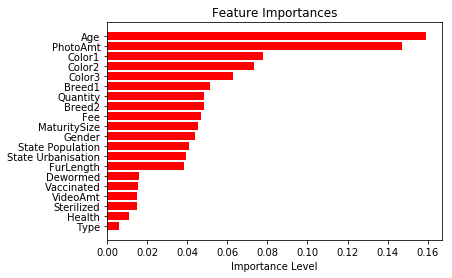

In [0]:
features = x.columns
importances = feature_importance_indicator.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance Level')
plt.show()

##For the key part of this kernel!!:

Now, in my mind there was something that was bugging me about the dataset, and that was the fact that dataset  was including dogs and cats together. Now I know a thing or two about pet adoption, and for me it is pretty obvious that the criteria a person uses when accepting a cat is rather different to that of adopting a dog. People simply take different things into account. Ultimately, different features would have different importance based whether it was a cat or a dog. 
Because i'm using some very narrow M.L here (just SciKit Learn Algorithms) was afraid that this distinction wouldn't be weighted strong enough in the model that tries to predict for both Cats and Dogs. 

So I decided to visualize the data to see how significant the difference was between cat and dog feature, to see if I could validate by theory or not. 

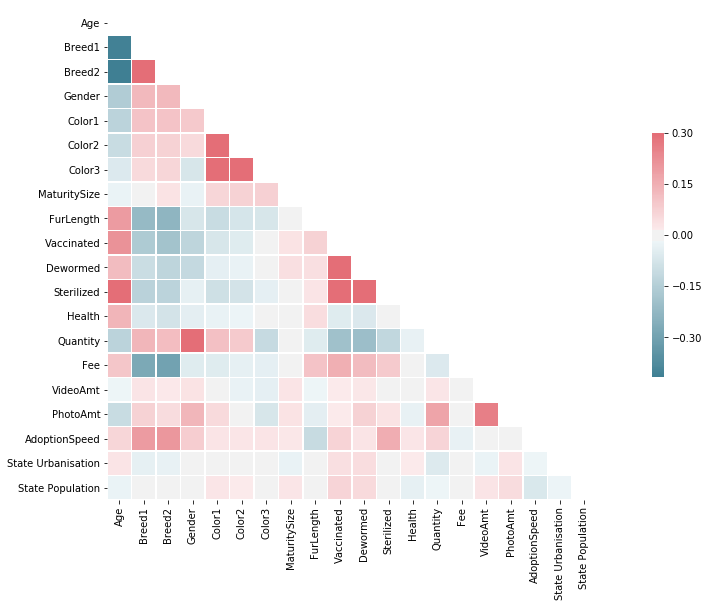

In [0]:
plot_correlation_matrix(data[data.Type==1].drop(columns=["Type"]))


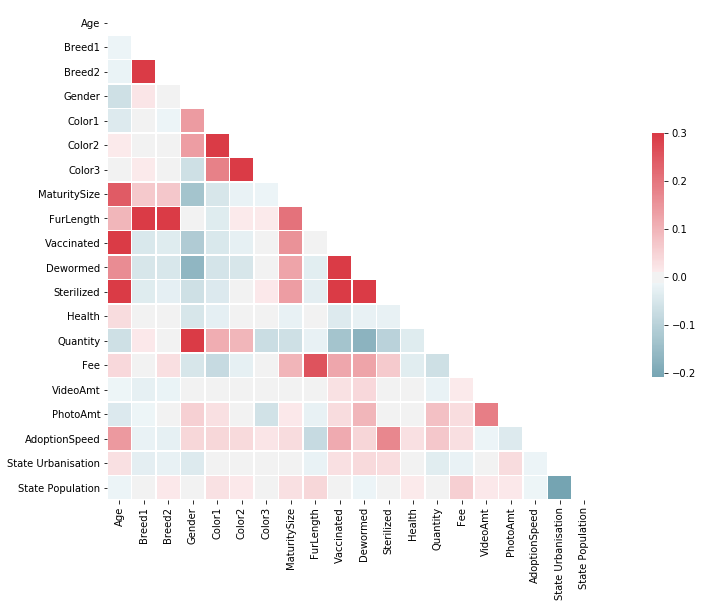

In [0]:
plot_correlation_matrix(data[data.Type==2].drop(columns=["Type"]))


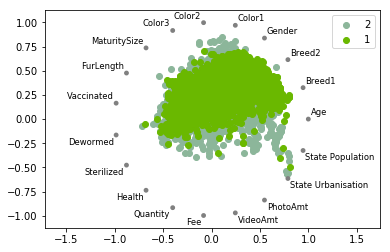

In [0]:
rad_viz = pd.plotting.radviz(x, 'Type')

In my opinion, the Correlation Matrixes show us that the two datasets are rather different indeed, different features seem to be correlated differently to one another depending on the Animal type.
Futhermore, if we have take a look at the Adoption Speed line, we can see some difference in the correlations between the two the matrixes.
Finally, the Radviz allows us to see that the cat data is a lot more spread out whereas the dog data is far more uniform. 

Therefore, I will try to seperate this dataset into two subdatasets ( one of cats, one of dogs) and train two different models on them.

In [0]:

#we create two datasets, one for dogs and one for cats to train seperate data on them.

dogdata = data[data.Type==1]
catdata = data[data.Type==2]


dog_x=dogdata.drop(columns=["AdoptionSpeed"])
dog_y=dogdata["AdoptionSpeed"]

cat_x=catdata.drop(columns=["AdoptionSpeed"])
cat_y=catdata["AdoptionSpeed"]


dog_x.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt',
       'State Urbanisation', 'State Population'],
      dtype='object')

And finally, if we look at the Feature Importance for the dog dataset and the cat dataset, we can see some subtle differences such as the importance of the fur lenght or the size.

This in my opinion, validates to try and seperate the two datasets.

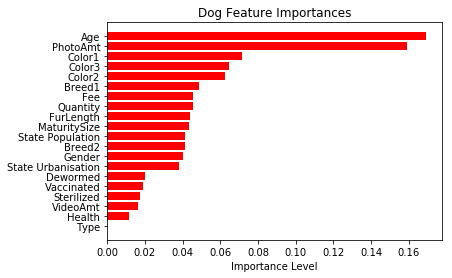

In [0]:
feature_importance_indicator.fit(dog_x,dog_y)
features = dog_x.columns
importances = feature_importance_indicator.feature_importances_
indices = np.argsort(importances)

plt.title('Dog Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance Level')
plt.show()

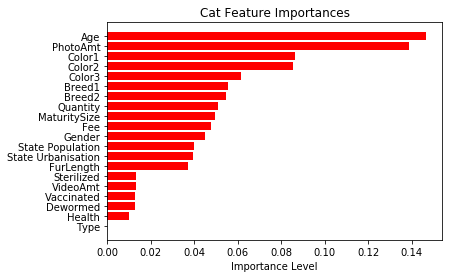

In [0]:
feature_importance_indicator.fit(cat_x,cat_y)
features = cat_x.columns
importances = feature_importance_indicator.feature_importances_
indices = np.argsort(importances)

plt.title('Cat Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance Level')
plt.show()


# Part 2- Data Learning

We'll now train our two datasets on different models. To find the optimal model for each dataset, I used the highly recommendable[ TPOT api](https://epistasislab.github.io/tpot/api/). TPOT uses genetic searching to give you the Sci kit learn model with the optimal hyperparameters. However, this process took roughly 8 hours overall. The models and hyperparameters used here below here the optimal models that the TPOT alogorithm found.

In [0]:

#splitting between train and test for the dog data
dog_x_training,dog_x_testing, dog_y_training, dog_y_testing = train_test_split(dog_x, dog_y, test_size=0.1, random_state=85)

#splitting between train and test for the cat data
cat_x_training,cat_x_testing,  cat_y_training, cat_y_testing = train_test_split(cat_x, cat_y, test_size=0.1, random_state=85)

dog_x_training.drop(columns="Type", inplace=True)
dog_x_testing.drop(columns="Type",inplace=True)
cat_x_training.drop(columns="Type",inplace=True)
cat_x_testing.drop(columns="Type",inplace=True)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Here is the best model found for the dogdata, GradientBoosting Classifier:

In [0]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


# Average CV score on the training set was:0.368919785590269

dog_best_model = make_pipeline(
    VarianceThreshold(threshold=0.0001),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=17, n_estimators=100, subsample=1.0)
)


dog_best_model.fit(dog_x_training, dog_y_training)



Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0001)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=0.5, max_leaf_nodes=None,
              min_impu...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

Now we can use our Quadratic Weighted Kappa (QWK) function from earlier to test it on our test data

In [0]:
y_true_train= np.array(dog_y_training)
y_pred_train = np.array(dog_best_model.predict(dog_x_training))

y_true_test= np.array(dog_y_testing)
y_pred_test = np.array(dog_best_model.predict(dog_x_testing))


print("On training data QWK:...",quadratic_kappa(y_true_train,y_pred_train),"on testing data QWK...",quadratic_kappa(y_true_test,y_pred_test))


On training data QWK:... 0.5592439709392605 on testing data QWK... 0.39103153291534876


Now for the cat data. Here the best model was found to be a Scaler along with XGBoost. The fact that the optimal models found for each dataset reinforces by point of view that cat data and dog data should be treated differently.

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


# Average CV score on the training set was:0.31768177281003007
cat_best_model = make_pipeline(
    StandardScaler(),
    XGBClassifier(learning_rate=0.1, max_depth=4, min_child_weight=13, n_estimators=100, nthread=1, subsample=0.7500000000000001)
)

cat_best_model.fit(cat_x_training,cat_y_training)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=13, missing=None, ...=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7500000000000001))])

In [0]:
y_true_train= np.array(cat_y_training)
y_pred_train = np.array(cat_best_model.predict(cat_x_training))

y_true_test= np.array(cat_y_testing)
y_pred_test = np.array(cat_best_model.predict(cat_x_testing))

print("On training data...",quadratic_kappa(y_true_train,y_pred_train),"on testing data...",quadratic_kappa(y_true_test,y_pred_test))


/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


On training data... 0.3924688064260007 on testing data... 0.33112080971591384


On a final note, I also ran TPOT on the whole data (cats on dogs put together), here the best QWK I was able to get on the test data was 0.31...  In my opinion, seperating the catdata from the dogdata is the right way to go in order to increase the performance of our models. I encourage others to try it with more complex models that use the image dataset and NLP.

# Part 3- Data Predicting

Let's know use these two models to generate our answers for the submision:

In [0]:
#Let's first retrain our models on the complete dataset
dog_best_model.fit(dog_x, dog_y)
cat_best_model.fit(cat_x,cat_y)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=13, missing=None, ...=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7500000000000001))])

In [0]:
#Loading the test data provided by Kaggle
test_data=pd.read_csv("../input/test/test.csv")


In [0]:
#Formatting the test data just like we did with the train data...
test_data.drop(columns=['RescuerID','Name','Description','PetID'], inplace=True)

test_data["State urbanisation"]=test_data["State"].map(states_ubran_dict)
test_data["State population"]=test_data["State"].map(states_pop_dict)
test_data.drop(columns="State", inplace= True)

test_data["Color2"]= test_data["Color2"].apply(lambda x: None if x==0 else x)
test_data["Color3"]= test_data["Color3"].apply(lambda x: None if x==0 else x)


test_data["Color1"]=test_data["Color1"].map(color_dictionary)
test_data["Color2"]=test_data["Color2"].map(color_dictionary)
test_data["Color3"]=test_data["Color3"].map(color_dictionary)

test_data["Color2"].fillna(test_data["Color1"],inplace=True)
test_data["Color3"].fillna(test_data["Color2"],inplace=True)

test_data["Breed1"]=test_data["Breed1"].map(breeds_dictionary)
test_data["Breed2"]=test_data["Breed2"].map(breeds_dictionary)

test_data["Breed2"].fillna(test_data["Breed1"],inplace=True)
test_data["Breed1"].fillna(test_data["Breed2"],inplace=True)

test_data["Vaccinated"]=test_data["Vaccinated"].apply(lambda x:1 if x==1 else 0)
test_data["Dewormed"]=test_data["Dewormed"].apply(lambda x:1 if x==1 else 0)
test_data["Sterilized"]=test_data["Sterilized"].apply(lambda x:1 if x==1 else 0)




test_data.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,VideoAmt,PhotoAmt,State urbanisation,State population
0,1,2,200.0,200.0,1,1.000,1.000,1.0,2,2,0,0,0,1,1,150,0,3.0,91.4,5411324.0
1,2,24,7.0,7.0,1,0.883,0.000,0.0,2,1,1,1,1,1,1,0,0,1.0,91.4,5411324.0
2,2,20,7.0,7.0,2,0.000,0.000,0.0,2,1,1,1,1,1,1,150,0,1.0,91.4,5411324.0
3,2,5,7.0,20.0,2,1.000,0.500,0.0,2,1,1,1,1,1,1,100,0,1.0,91.4,5411324.0
4,1,6,200.0,200.0,2,1.000,0.883,0.0,2,1,1,1,1,1,1,150,0,1.0,91.4,5411324.0


In [0]:
#Making sure the formatting was done correctly
if len(test_data.columns)==len(dog_x.columns):
  print("Formatting done correctly")
else:
    print("H we have a problem, double check previous cell")

Formatting done correctly


In order to apply the models correspondingly, I built the function below that discriminates between dogs and cats in the Test data and uses the correct model on that specific row.

In [0]:
#We'll store our answers in this dictionary so that we can map them onto the submission file
answers_dictionary={}

def test_predicitions(test_data):
    assert type(test_data)==type(data)
    for i in range (len(test_data)):
        if int(test_data["Type"].iloc[[i,]])==1:
            test_data.iloc[[i,]].drop(columns="Type")
            answers_dictionary[test_data.index[i]]=int(dog_best_model.predict(test_data.iloc[[i,]]))
        else:
            test_data.iloc[[i,]].drop(columns="Type")
            answers_dictionary[test_data.index[i]]=int(cat_best_model.predict(test_data.iloc[[i,]]))

test_predicitions(test_data)     


/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = tran

In [0]:
submission_answer=pd.read_csv("../input/test/sample_submission.csv")

submission_answer.head()



,PetID,AdoptionSpeed
0,378fcc4fc,0
1,73c10e136,0
2,72000c4c5,0
3,e147a4b9f,0
4,43fbba852,0


In [0]:
#we map our asnwers from our two different models onto the submission file
submission_answer["AdoptionSpeed"]= submission_answer.index.map(answers_dictionary.get)

submission_answer.head()

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4


In [0]:
submission_answer.to_csv('submission.csv', index=False)

# Conclusion

My conclusion is that I think this problem needs to be treated as one with two independent sub-sets of data. From my own experience, when I seperated the cat of the dogs, my models, as simple as they were, improved significantly. I am therefore exicted to see if others take this approach and can get even better results by seperating the two datasets with the use of DL, Computer vision and Sentiment Analysis.